Project Overview

This project aims to predict an NBA player's points, rebounds and assists scored in a game
based on historical game statistics.
It is a Supervised Learning problem (Regression task).
We will explore results using Linear Regression models, Ridge Regression,
Random Forest Regression, and Kernel Density Estimation
to analyze player performance.

This model can be used for Sportsbetting, as you can see what betting lines have value relative to their
chance of hitting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from google.colab import drive
from scipy.stats import norm
import ipywidgets as widgets
from IPython.display import display
from sklearn.linear_model import Ridge
from scipy.stats import gaussian_kde





Data Source

This project uses publicly available data found at https://www.kaggle.com/datasets/eoinamoore/historical-nba-data-and-player-box-scores?resource=download by Eoin A Moore

This dataset consists of tabular data in several files such as TeamStatistics, PlayerStatistics, Games and LeagueSchedule, collectively being 97 MB in size.

These files conosist of numerical data such as points and rebounds, as well of categorical data like firstName, lastName, teamName, gameType, etc.


Data Cleaning

We begin by cleaning the dataset to ensure that it is suitable for analysis. For this project, only Player Statistics was used.Some key steps include:

1. **Handling missing values**: If there are any NaN or null values in the dataset, we will either impute them with the mean/median or drop rows with missing values.
2. **Feature selection**: We select only the most relevant features (e.g., points, rebounds, assists)
3. **Removing outliers**: We filter out extreme outliers for the specific stats as well as minutes played.

The following visualizations highlight the distribution of these features and check for any missing data or outliers.

In [2]:
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/NBADatabase/'

player_stats = pd.read_csv(folder_path + 'PlayerStatistics.csv')

selected_columns = [
    'firstName', 'lastName', 'numMinutes', 'assists', 'blocks', 'steals',
    'fieldGoalsPercentage', 'threePointersPercentage', 'freeThrowsPercentage',
    'fieldGoalsAttempted', 'threePointersAttempted', 'freeThrowsAttempted',
    'reboundsDefensive', 'reboundsOffensive', 'reboundsTotal', 'turnovers', 'plusMinusPoints',
    'opponentteamName', 'playerteamName', 'gameType', 'home', 'gameDate',
    'points'
]

player_stats = player_stats[selected_columns]

player_stats = player_stats.dropna(subset=['numMinutes', 'fieldGoalsPercentage', 'points'])

player_stats.head()

Mounted at /content/drive


<ipython-input-2-12a4c402a856>:4: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  player_stats = pd.read_csv(folder_path + 'PlayerStatistics.csv')


,firstName,lastName,numMinutes,assists,blocks,steals,fieldGoalsPercentage,threePointersPercentage,freeThrowsPercentage,fieldGoalsAttempted,...,reboundsOffensive,reboundsTotal,turnovers,plusMinusPoints,opponentteamName,playerteamName,gameType,home,gameDate,points
0,LeBron,James,41.09,4.0,2.0,2.0,0.619,0.556,0.70,21.0,...,3.0,10.0,1.0,-10.0,Timberwolves,Lakers,Playoffs,0,2025-04-25 21:30:00,38.0
1,Mike,Conley,21.01,4.0,0.0,1.0,0.667,1.000,0.00,6.0,...,1.0,3.0,0.0,6.0,Lakers,Timberwolves,Playoffs,1,2025-04-25 21:30:00,9.0
3,Alex,Len,0.39,0.0,0.0,0.0,0.000,0.000,0.00,0.0,...,0.0,0.0,0.0,0.0,Timberwolves,Lakers,Playoffs,0,2025-04-25 21:30:00,0.0
4,Rudy,Gobert,25.24,1.0,1.0,2.0,0.000,0.000,0.25,0.0,...,1.0,3.0,1.0,3.0,Lakers,Timberwolves,Playoffs,1,2025-04-25 21:30:00,1.0
5,Julius,Randle,40.57,4.0,0.0,1.0,0.462,0.250,0.90,13.0,...,0.0,5.0,2.0,11.0,Lakers,Timberwolves,Playoffs,1,2025-04-25 21:30:00,22.0


The following is some exploratory data analysis including histograms and boxplots. As you can see by plotting points, rebounds, and assists against opponent team, certain opponent teams allow for more stats than others. This is over the course of decades, but the players we will test for will be tested with the data of their era.

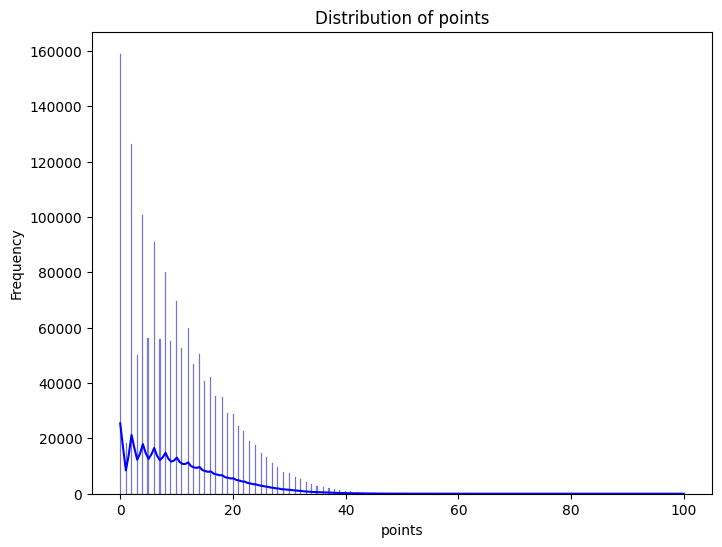

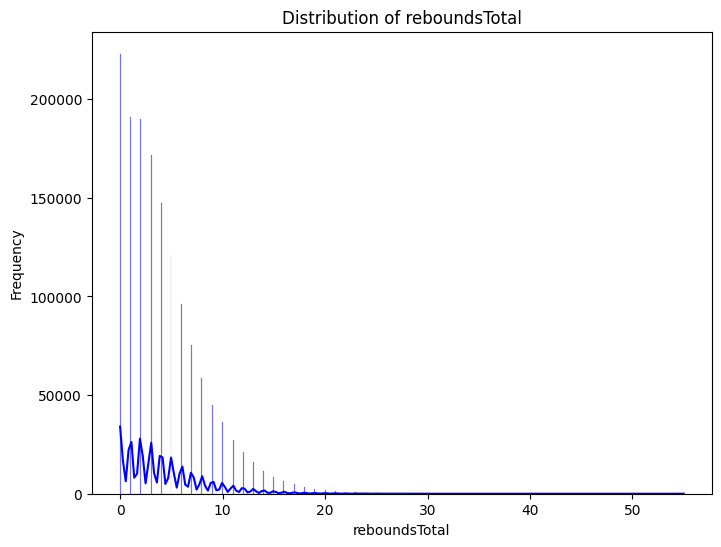

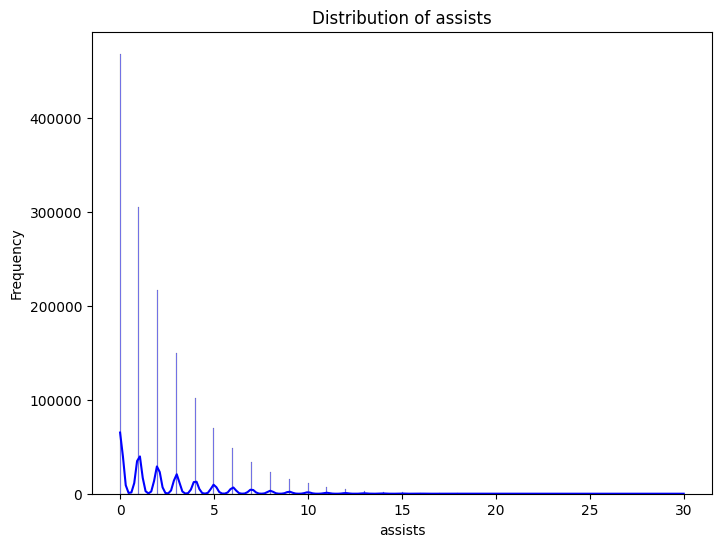

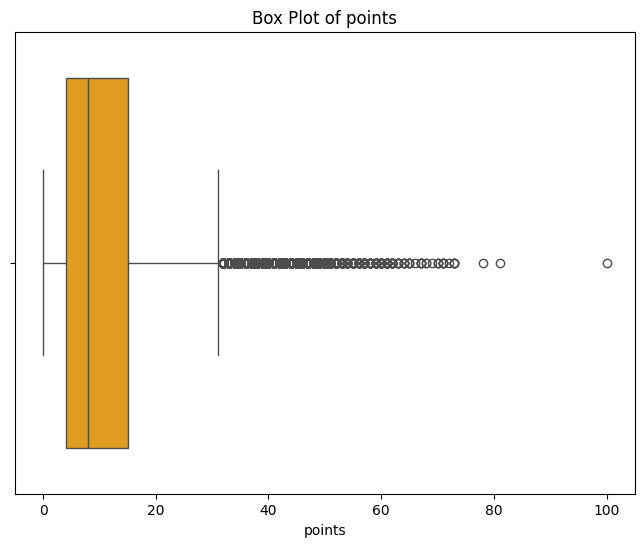

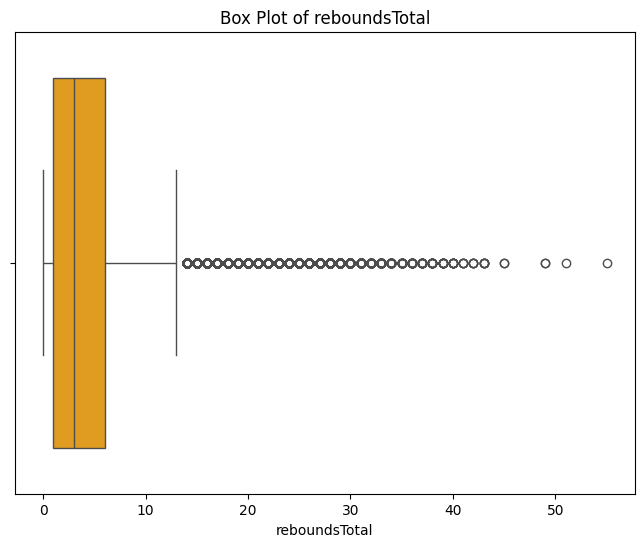

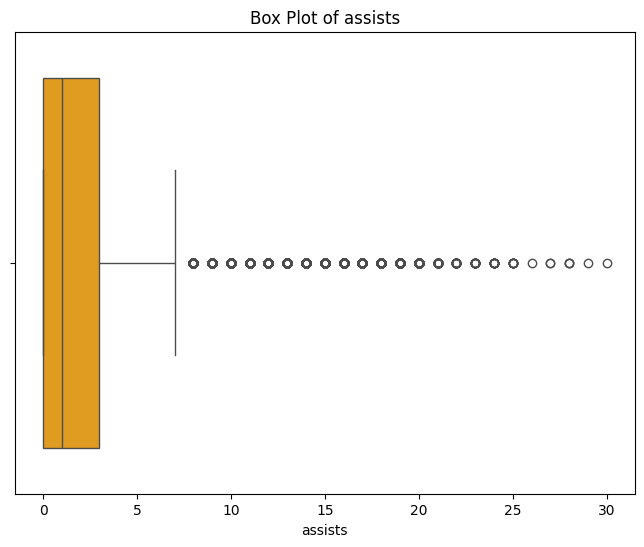

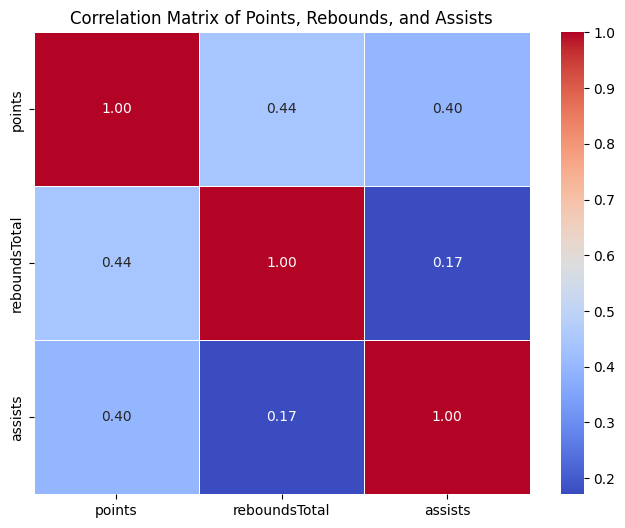

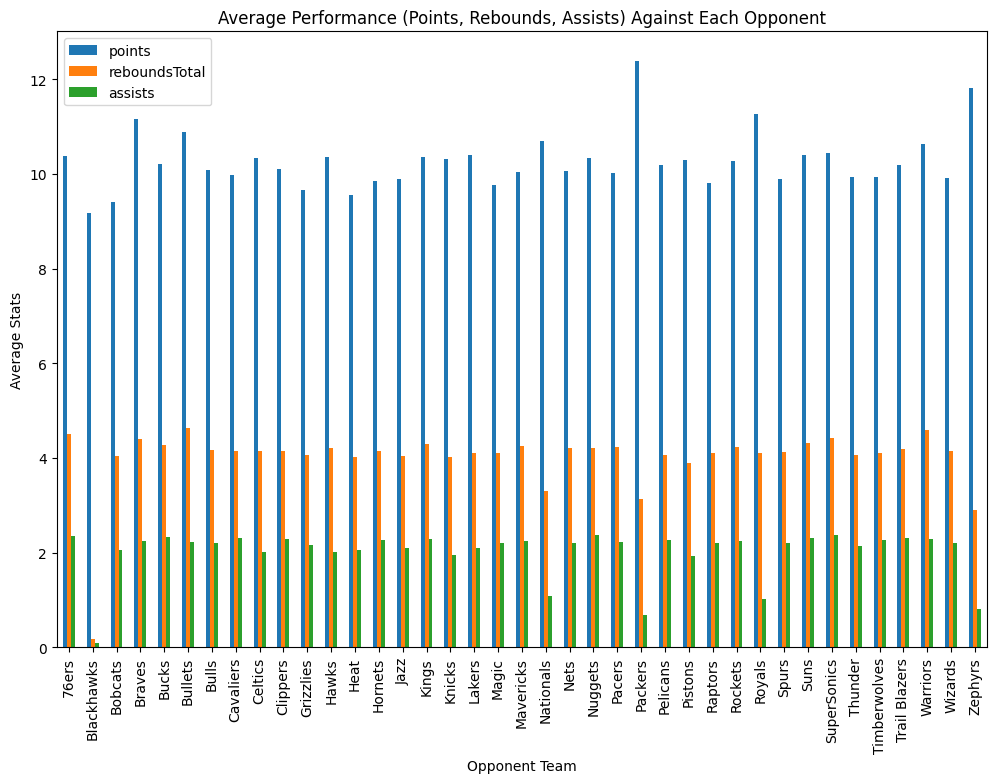

In [3]:
features = ['points', 'reboundsTotal', 'assists']

# Plotting histograms for each feature
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.histplot(player_stats[feature], kde=True, color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Plotting box plots for each feature to check for outliers
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=player_stats[feature], color='orange')
    plt.title(f'Box Plot of {feature}')
    plt.xlabel(feature)
    plt.show()


corr_matrix = player_stats[['points', 'reboundsTotal', 'assists']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Points, Rebounds, and Assists")
plt.show()

opponent_stats = player_stats.groupby('opponentteamName')[['points', 'reboundsTotal', 'assists']].mean()

# Visualizing the performance against different opponents
opponent_stats.plot(kind='bar', figsize=(12, 8))
plt.title('Average Performance (Points, Rebounds, Assists) Against Each Opponent')
plt.ylabel('Average Stats')
plt.xlabel('Opponent Team')
plt.xticks(rotation=90)
plt.show()

This is the initial linear regression model that can be used for points, rebounds or assists.
It uses the players's last 20 overall games as well as the player's last 10 games against
the specific opponent. A trendline is created based on those games to determine a prediction for the next game.
Based on those 30 games, a standard deviation is created and used to build a normal distribution around that
prediction to see confidence levels for other point/rebound/assist totals.
A gameNumber feature is created to track the games.
'''


=== Stephen Curry vs Rockets (Home) ===


 POINTS Prediction:

 Recent Form Games for Points:


,gameDate,opponentteamName,points,numMinutes,home
17003,2025-01-18 20:30:00,Wizards,26.0,34.14,1
16603,2025-01-20 17:00:00,Celtics,18.0,27.00,1
15999,2025-01-23 22:00:00,Bulls,21.0,30.47,1
15587,2025-01-25 20:30:00,Lakers,13.0,32.09,1
14820,2025-01-29 22:00:00,Thunder,21.0,33.18,1
14501,2025-01-31 22:00:00,Suns,14.0,31.13,1
13878,2025-02-03 22:00:00,Magic,24.0,34.18,1
11116,2025-02-23 15:30:00,Mavericks,30.0,28.34,1
10495,2025-02-25 22:00:00,Hornets,15.0,23.39,1
8272,2025-03-08 20:30:00,Pistons,32.0,33.27,1



 Matchup Games for Points:


,gameDate,opponentteamName,points,numMinutes,home
222310,2019-02-23 20:30:00,Rockets,25.0,35.0,1
212683,2019-04-28 15:30:00,Rockets,18.0,37.0,1
212579,2019-04-30 22:30:00,Rockets,20.0,33.0,1
212242,2019-05-08 22:30:00,Rockets,25.0,43.0,1
139627,2021-11-07 20:30:00,Rockets,20.0,26.0,1
125793,2022-01-21 22:00:00,Rockets,22.0,38.0,1
98419,2022-12-03 20:30:00,Rockets,30.0,34.0,1
65349,2023-11-20 22:00:00,Rockets,32.0,34.0,1


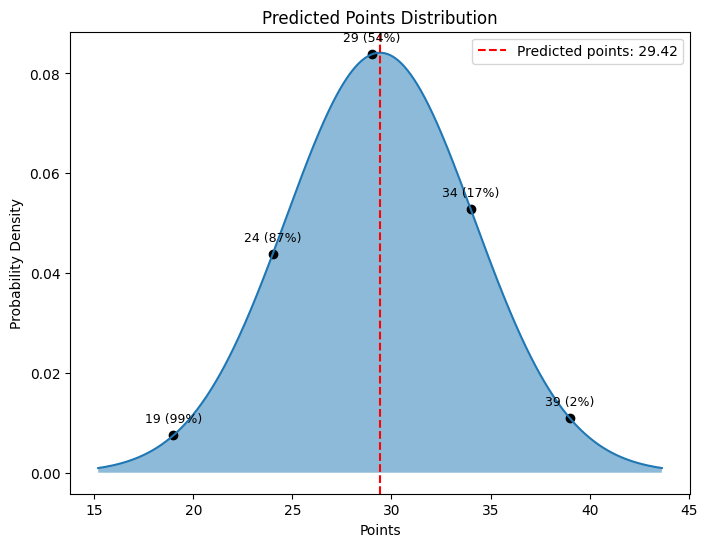


 Interactive Probability Slider for Points:


IntSlider(value=29, continuous_update=False, description='points', max=49, min=19)

Output()


 REBOUNDS Prediction:

 Recent Form Games for Reboundstotal:


,gameDate,opponentteamName,reboundsTotal,numMinutes,home
17003,2025-01-18 20:30:00,Wizards,5.0,34.14,1
16603,2025-01-20 17:00:00,Celtics,3.0,27.00,1
15999,2025-01-23 22:00:00,Bulls,4.0,30.47,1
14820,2025-01-29 22:00:00,Thunder,1.0,33.18,1
14501,2025-01-31 22:00:00,Suns,3.0,31.13,1
13878,2025-02-03 22:00:00,Magic,1.0,34.18,1
11116,2025-02-23 15:30:00,Mavericks,4.0,28.34,1
10495,2025-02-25 22:00:00,Hornets,4.0,23.39,1
8272,2025-03-08 20:30:00,Pistons,3.0,33.27,1
7746,2025-03-10 22:00:00,Trail Blazers,2.0,34.01,1



 Matchup Games for Reboundstotal:


,gameDate,opponentteamName,reboundsTotal,numMinutes,home
212683,2019-04-28 15:30:00,Rockets,7.0,37.0,1
212579,2019-04-30 22:30:00,Rockets,3.0,33.0,1
212242,2019-05-08 22:30:00,Rockets,6.0,43.0,1
156697,2021-04-10 22:00:00,Rockets,8.0,34.0,1
139627,2021-11-07 20:30:00,Rockets,3.0,26.0,1
125793,2022-01-21 22:00:00,Rockets,4.0,38.0,1
98419,2022-12-03 20:30:00,Rockets,3.0,34.0,1
65349,2023-11-20 22:00:00,Rockets,5.0,34.0,1


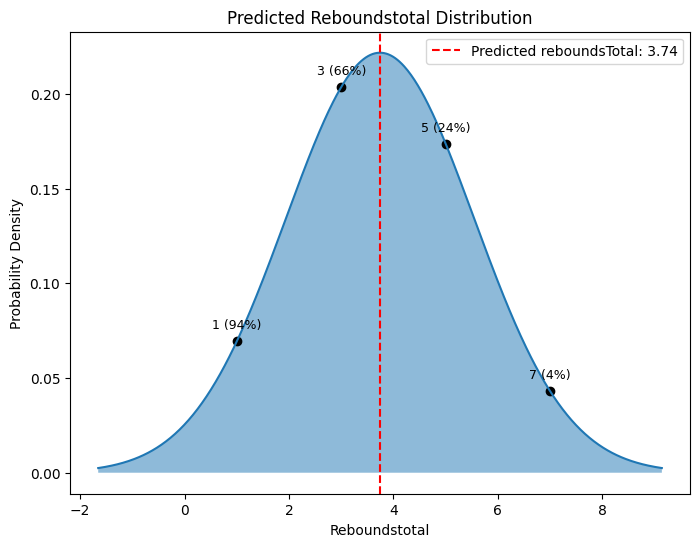


 Interactive Probability Slider for Reboundstotal:


IntSlider(value=3, continuous_update=False, description='reboundsTotal', max=23, min=-6)

Output()


 ASSISTS Prediction:

 Recent Form Games for Assists:


,gameDate,opponentteamName,assists,numMinutes,home
17003,2025-01-18 20:30:00,Wizards,6.0,34.14,1
16603,2025-01-20 17:00:00,Celtics,4.0,27.00,1
15999,2025-01-23 22:00:00,Bulls,7.0,30.47,1
14820,2025-01-29 22:00:00,Thunder,4.0,33.18,1
14501,2025-01-31 22:00:00,Suns,3.0,31.13,1
13878,2025-02-03 22:00:00,Magic,5.0,34.18,1
11116,2025-02-23 15:30:00,Mavericks,7.0,28.34,1
10495,2025-02-25 22:00:00,Hornets,6.0,23.39,1
8272,2025-03-08 20:30:00,Pistons,4.0,33.27,1
7746,2025-03-10 22:00:00,Trail Blazers,3.0,34.01,1



 Matchup Games for Assists:


,gameDate,opponentteamName,assists,numMinutes,home
222310,2019-02-23 20:30:00,Rockets,7.0,35.0,1
212683,2019-04-28 15:30:00,Rockets,4.0,37.0,1
212579,2019-04-30 22:30:00,Rockets,5.0,33.0,1
212242,2019-05-08 22:30:00,Rockets,5.0,43.0,1
156697,2021-04-10 22:00:00,Rockets,5.0,34.0,1
139627,2021-11-07 20:30:00,Rockets,2.0,26.0,1
98419,2022-12-03 20:30:00,Rockets,10.0,34.0,1
2305,2025-04-06 20:30:00,Rockets,8.0,32.4,1


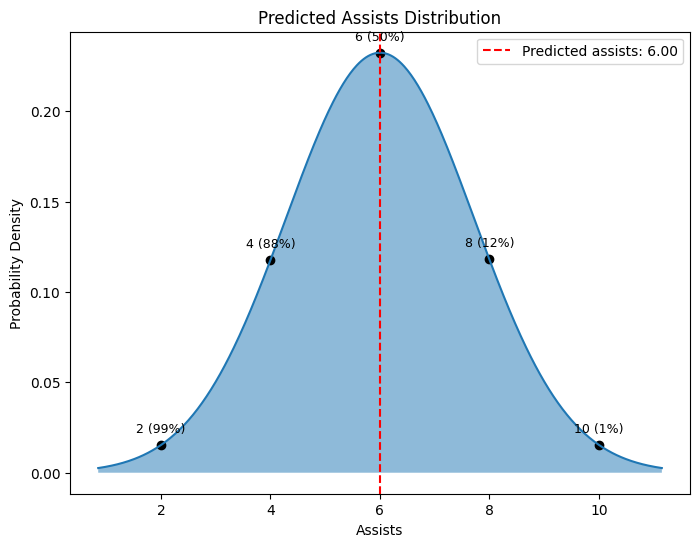


 Interactive Probability Slider for Assists:


IntSlider(value=6, continuous_update=False, description='assists', max=26, min=-3)

Output()


📋 SUMMARY REPORT:


,Stat,Predicted Value
0,Points,29.42
1,Rebounds,3.74
2,Assists,6.00



 Full Player Report Complete!


In [4]:
#Linear Regression
def drop_highest_and_lowest(df, column='points'):
    if len(df) <= 2:
        return df
    idx_max = df[column].idxmax()
    idx_min = df[column].idxmin()
    df = df.drop([idx_max, idx_min])
    return df

def predict_stat_distribution(stat_name, first_name, last_name, opponent_team, is_home_game):
    if not np.issubdtype(player_stats['gameDate'].dtype, np.datetime64):
        player_stats['gameDate'] = pd.to_datetime(player_stats['gameDate'])
    filtered_stats = player_stats[player_stats['numMinutes'] >= 10]
    all_games = filtered_stats[
        (filtered_stats['firstName'] == first_name) &
        (filtered_stats['lastName'] == last_name)
    ].sort_values('gameDate')
    opponent_games = all_games[all_games['opponentteamName'] == opponent_team]

    if all_games.empty or opponent_games.empty:
        print(f"No sufficient data for {first_name} {last_name} vs {opponent_team}.")
        return None, None

    recent_games = all_games[all_games['home'] == is_home_game].tail(20)
    recent_opponent_games = opponent_games[opponent_games['home'] == is_home_game].tail(10)

    if recent_games.empty or recent_opponent_games.empty:
        print(f"No recent or matchup games found.")
        return None, None

    recent_games = drop_highest_and_lowest(recent_games, column=stat_name)
    recent_opponent_games = drop_highest_and_lowest(recent_opponent_games, column=stat_name)

    print(f"\n Recent Form Games for {stat_name.capitalize()}:")
    display(recent_games[['gameDate', 'opponentteamName', stat_name, 'numMinutes', 'home']])
    print(f"\n Matchup Games for {stat_name.capitalize()}:")
    display(recent_opponent_games[['gameDate', 'opponentteamName', stat_name, 'numMinutes', 'home']])

    recent_games = recent_games.reset_index(drop=True)
    recent_games['gameNumber'] = np.arange(len(recent_games))
    X_recent = recent_games['gameNumber'].values.reshape(-1,1)
    y_recent = recent_games[stat_name].values
    model_recent = LinearRegression()
    model_recent.fit(X_recent, y_recent)

    recent_opponent_games = recent_opponent_games.reset_index(drop=True)
    recent_opponent_games['gameNumber'] = np.arange(len(recent_opponent_games))
    X_opponent = recent_opponent_games['gameNumber'].values.reshape(-1,1)
    y_opponent = recent_opponent_games[stat_name].values
    model_opponent = LinearRegression()
    model_opponent.fit(X_opponent, y_opponent)

    pred_recent = model_recent.predict(np.array([[len(recent_games)]]))[0]
    pred_opponent = model_opponent.predict(np.array([[len(recent_opponent_games)]]))[0]
    final_pred = 0.6 * pred_recent + 0.4 * pred_opponent

    r2_recent = model_recent.score(X_recent, y_recent)
    r2_opponent = model_opponent.score(X_opponent, y_opponent)
    avg_r2 = (r2_recent + r2_opponent) / 2
    base_std_dev = np.std(np.concatenate([y_recent, y_opponent]))
    adj_std_dev = base_std_dev * (1 - avg_r2)
    adj_std_dev = max(adj_std_dev, 1)

    x = np.linspace(final_pred - 3*adj_std_dev, final_pred + 3*adj_std_dev, 500)
    y = norm.pdf(x, final_pred, adj_std_dev)

    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(x, y)
    ax.fill_between(x, y, alpha=0.5)
    ax.axvline(final_pred, color='red', linestyle='--', label=f'Predicted {stat_name}: {final_pred:.2f}')

    thresholds = []
    if final_pred <= 10:
        thresholds = [int(final_pred - 4), int(final_pred - 2), int(final_pred), int(final_pred + 2), int(final_pred + 4)]
    elif final_pred <= 20:
        thresholds = [int(final_pred - 6), int(final_pred - 3), int(final_pred), int(final_pred + 3), int(final_pred + 6)]
    else:
        thresholds = [int(final_pred - 10), int(final_pred - 5), int(final_pred), int(final_pred + 5), int(final_pred + 10)]
    thresholds = [thresh for thresh in thresholds if thresh > 0]

    for thresh in thresholds:
        y_thresh = norm.pdf(thresh, final_pred, adj_std_dev)
        prob = (1 - norm.cdf(thresh, final_pred, adj_std_dev)) * 100
        ax.scatter(thresh, y_thresh, color='black')
        ax.text(thresh, y_thresh + max(y)*0.03, f'{thresh} ({prob:.0f}%)',
                ha='center', fontsize=9, color='black')

    ax.set_title(f'Predicted {stat_name.capitalize()} Distribution')
    ax.set_xlabel(f'{stat_name.capitalize()}')
    ax.set_ylabel('Probability Density')
    ax.legend()
    plt.show()

    print(f"\n Interactive Probability Slider for {stat_name.capitalize()}:")
    slider = widgets.IntSlider(
        value=int(final_pred),
        min=int(final_pred - 10),
        max=int(final_pred + 20),
        step=1,
        description=f'{stat_name}',
        continuous_update=False
    )
    def calculate_probability(threshold):
        prob = 1 - norm.cdf(threshold, final_pred, adj_std_dev)
        print(f" Probability of more than {threshold} {stat_name}: {prob*100:.2f}%")
    output = widgets.interactive_output(calculate_probability, {'threshold': slider})
    display(slider, output)

    return final_pred, adj_std_dev

def player_full_report(first_name, last_name, opponent_team, is_home_game):
    print(f"\n=== {first_name} {last_name} vs {opponent_team} ({'Home' if is_home_game else 'Away'}) ===\n")

    print("\n POINTS Prediction:")
    points_pred, points_std = predict_stat_distribution('points', first_name, last_name, opponent_team, is_home_game)

    print("\n REBOUNDS Prediction:")
    rebounds_pred, rebounds_std = predict_stat_distribution('reboundsTotal', first_name, last_name, opponent_team, is_home_game)

    print("\n ASSISTS Prediction:")
    assists_pred, assists_std = predict_stat_distribution('assists', first_name, last_name, opponent_team, is_home_game)

    print("\n📋 SUMMARY REPORT:")
    summary_data = {
        'Stat': ['Points', 'Rebounds', 'Assists'],
        'Predicted Value': [
            f'{points_pred:.2f}' if points_pred else 'N/A',
            f'{rebounds_pred:.2f}' if rebounds_pred else 'N/A',
            f'{assists_pred:.2f}' if assists_pred else 'N/A'
        ]
    }
    summary_df = pd.DataFrame(summary_data)
    display(summary_df)
    print("\n Full Player Report Complete!")


player_full_report('Stephen', 'Curry', 'Rockets', is_home_game=1)



This is a simulated comparison between different models.
Conclusion: Random Forest Regression is much more accurate than Linear Regression over time.

In [5]:
#Ridge Regression, Random Forest, and Linear Regression Comparison
def prepare_recent_data(first_name, last_name, is_home_game):
    filtered_stats = player_stats[player_stats['numMinutes'] >= 10]
    if not np.issubdtype(player_stats['gameDate'].dtype, np.datetime64):
        player_stats['gameDate'] = pd.to_datetime(player_stats['gameDate'])

    all_games = filtered_stats[
        (filtered_stats['firstName'] == first_name) &
        (filtered_stats['lastName'] == last_name) &
        (filtered_stats['home'] == is_home_game)
    ].sort_values('gameDate')

    all_games = all_games.tail(20)
    all_games = drop_highest_and_lowest(all_games, column='points')

    all_games = all_games.reset_index(drop=True)
    all_games['gameNumber'] = np.arange(len(all_games))

    X = all_games[['gameNumber']]
    y = all_games['points']

    return X, y

def train_and_compare_models(first_name, last_name, is_home_game=1):
    X, y = prepare_recent_data(first_name, last_name, is_home_game)

    # Linear Regression
    lin_model = LinearRegression()
    lin_model.fit(X, y)
    lin_preds = lin_model.predict(X)

    # Ridge Regression
    ridge_model = Ridge(alpha=1.0)
    ridge_model.fit(X, y)
    ridge_preds = ridge_model.predict(X)

    # Random Forest Regressor with hyperparameter tuning
    rf_model = RandomForestRegressor(random_state=42)
    param_grid = {'max_depth': [3, 5, 7, 10, None]}
    grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='neg_mean_absolute_error')
    grid_search.fit(X, y)
    best_rf_model = grid_search.best_estimator_
    rf_preds = best_rf_model.predict(X)

    #Evaluate
    models = {
        'Linear Regression': lin_preds,
        'Ridge Regression': ridge_preds,
        'Random Forest Regressor': rf_preds
    }

    print("\n Model Comparison Metrics\n")
    results = []
    for name, preds in models.items():
        mae = mean_absolute_error(y, preds)
        rmse = mean_squared_error(y, preds) ** 0.5
        results.append((name, mae, rmse))
        print(f"{name}: MAE = {mae:.2f}, RMSE = {rmse:.2f}")

    results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE'])
    display(results_df)

    print("\n Best Random Forest Parameters:")
    print(grid_search.best_params_)

train_and_compare_models('Stephen', 'Curry', is_home_game=1)


 Model Comparison Metrics

Linear Regression: MAE = 5.67, RMSE = 6.78
Ridge Regression: MAE = 5.67, RMSE = 6.78
Random Forest Regressor: MAE = 3.93, RMSE = 4.57


,Model,MAE,RMSE
0,Linear Regression,5.666017,6.776244
1,Ridge Regression,5.666451,6.776247
2,Random Forest Regressor,3.933326,4.574306



 Best Random Forest Parameters:
{'max_depth': 3}


This is the player prediction model using Random Forest Regression.
It still uses the players's last 20 overall games as well as the player's last 10 games against
the specific opponent. A trendline is created based on those games to determine a prediction for the next game.
Conclusion: While the center is more accurate, the spread of the model isn't very realistic.
In the example, Stephen Curry vs the Rockets,
it simply isnt realistic that there is a 100% chance of him scoring 27 or more points.


=== Stephen Curry vs Rockets (Home) ===


 POINTS Prediction:

 Recent Form Games for Points:


,gameDate,opponentteamName,points,numMinutes,home
17003,2025-01-18 20:30:00,Wizards,26.0,34.14,1
16603,2025-01-20 17:00:00,Celtics,18.0,27.00,1
15999,2025-01-23 22:00:00,Bulls,21.0,30.47,1
15587,2025-01-25 20:30:00,Lakers,13.0,32.09,1
14820,2025-01-29 22:00:00,Thunder,21.0,33.18,1
14501,2025-01-31 22:00:00,Suns,14.0,31.13,1
13878,2025-02-03 22:00:00,Magic,24.0,34.18,1
11116,2025-02-23 15:30:00,Mavericks,30.0,28.34,1
10495,2025-02-25 22:00:00,Hornets,15.0,23.39,1
8272,2025-03-08 20:30:00,Pistons,32.0,33.27,1



 Matchup Games for Points:


,gameDate,opponentteamName,points,numMinutes,home
222310,2019-02-23 20:30:00,Rockets,25.0,35.0,1
212683,2019-04-28 15:30:00,Rockets,18.0,37.0,1
212579,2019-04-30 22:30:00,Rockets,20.0,33.0,1
212242,2019-05-08 22:30:00,Rockets,25.0,43.0,1
139627,2021-11-07 20:30:00,Rockets,20.0,26.0,1
125793,2022-01-21 22:00:00,Rockets,22.0,38.0,1
98419,2022-12-03 20:30:00,Rockets,30.0,34.0,1
65349,2023-11-20 22:00:00,Rockets,32.0,34.0,1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


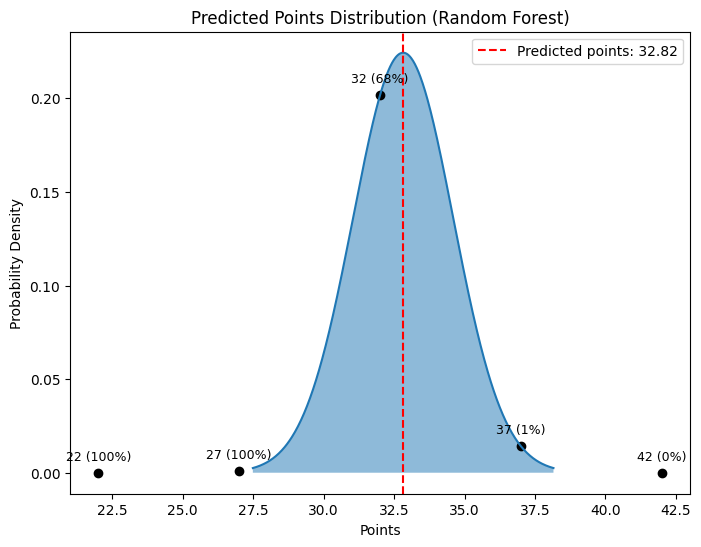


 Interactive Probability Slider for Points:


IntSlider(value=32, continuous_update=False, description='points', max=52, min=22)

Output()


 REBOUNDS Prediction:

 Recent Form Games for Reboundstotal:


,gameDate,opponentteamName,reboundsTotal,numMinutes,home
17003,2025-01-18 20:30:00,Wizards,5.0,34.14,1
16603,2025-01-20 17:00:00,Celtics,3.0,27.00,1
15999,2025-01-23 22:00:00,Bulls,4.0,30.47,1
14820,2025-01-29 22:00:00,Thunder,1.0,33.18,1
14501,2025-01-31 22:00:00,Suns,3.0,31.13,1
13878,2025-02-03 22:00:00,Magic,1.0,34.18,1
11116,2025-02-23 15:30:00,Mavericks,4.0,28.34,1
10495,2025-02-25 22:00:00,Hornets,4.0,23.39,1
8272,2025-03-08 20:30:00,Pistons,3.0,33.27,1
7746,2025-03-10 22:00:00,Trail Blazers,2.0,34.01,1



 Matchup Games for Reboundstotal:


,gameDate,opponentteamName,reboundsTotal,numMinutes,home
212683,2019-04-28 15:30:00,Rockets,7.0,37.0,1
212579,2019-04-30 22:30:00,Rockets,3.0,33.0,1
212242,2019-05-08 22:30:00,Rockets,6.0,43.0,1
156697,2021-04-10 22:00:00,Rockets,8.0,34.0,1
139627,2021-11-07 20:30:00,Rockets,3.0,26.0,1
125793,2022-01-21 22:00:00,Rockets,4.0,38.0,1
98419,2022-12-03 20:30:00,Rockets,3.0,34.0,1
65349,2023-11-20 22:00:00,Rockets,5.0,34.0,1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


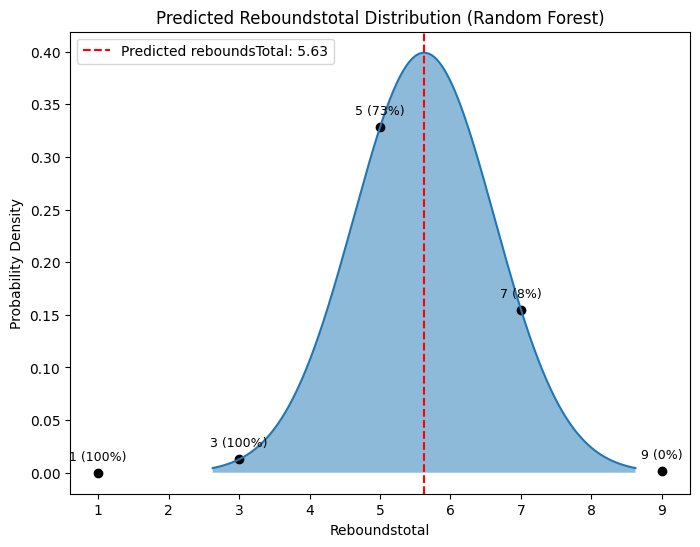


 Interactive Probability Slider for Reboundstotal:


IntSlider(value=5, continuous_update=False, description='reboundsTotal', max=25, min=-4)

Output()


 ASSISTS Prediction:

 Recent Form Games for Assists:


,gameDate,opponentteamName,assists,numMinutes,home
17003,2025-01-18 20:30:00,Wizards,6.0,34.14,1
16603,2025-01-20 17:00:00,Celtics,4.0,27.00,1
15999,2025-01-23 22:00:00,Bulls,7.0,30.47,1
14820,2025-01-29 22:00:00,Thunder,4.0,33.18,1
14501,2025-01-31 22:00:00,Suns,3.0,31.13,1
13878,2025-02-03 22:00:00,Magic,5.0,34.18,1
11116,2025-02-23 15:30:00,Mavericks,7.0,28.34,1
10495,2025-02-25 22:00:00,Hornets,6.0,23.39,1
8272,2025-03-08 20:30:00,Pistons,4.0,33.27,1
7746,2025-03-10 22:00:00,Trail Blazers,3.0,34.01,1



 Matchup Games for Assists:


,gameDate,opponentteamName,assists,numMinutes,home
222310,2019-02-23 20:30:00,Rockets,7.0,35.0,1
212683,2019-04-28 15:30:00,Rockets,4.0,37.0,1
212579,2019-04-30 22:30:00,Rockets,5.0,33.0,1
212242,2019-05-08 22:30:00,Rockets,5.0,43.0,1
156697,2021-04-10 22:00:00,Rockets,5.0,34.0,1
139627,2021-11-07 20:30:00,Rockets,2.0,26.0,1
98419,2022-12-03 20:30:00,Rockets,10.0,34.0,1
2305,2025-04-06 20:30:00,Rockets,8.0,32.4,1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


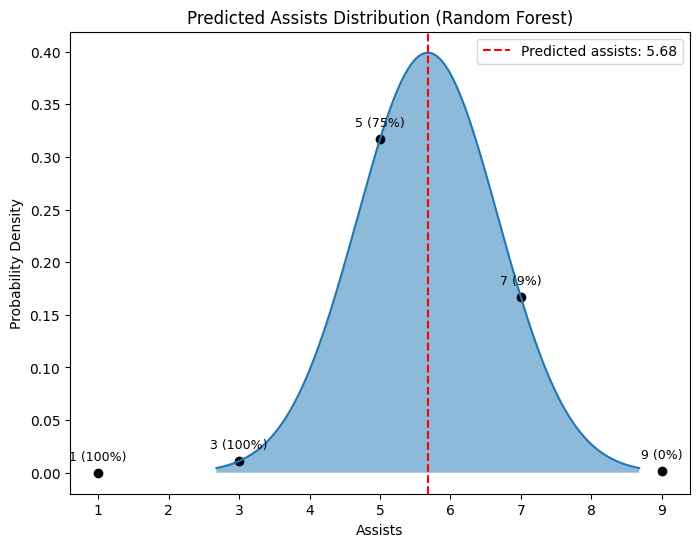


 Interactive Probability Slider for Assists:


IntSlider(value=5, continuous_update=False, description='assists', max=25, min=-4)

Output()


 SUMMARY REPORT:


,Stat,Predicted Value
0,Points,32.82
1,Rebounds,5.63
2,Assists,5.68



 Full Player Report Complete!


In [6]:
# Random Forest Player Prediction

# Helper: Drop highest and lowest scoring games
def drop_highest_and_lowest(df, column='points'):
    if len(df) <= 2:
        return df
    idx_max = df[column].idxmax()
    idx_min = df[column].idxmin()
    df = df.drop([idx_max, idx_min])
    return df

# Main Predict Function (Random Forest version)
def predict_stat_distribution(stat_name, first_name, last_name, opponent_team, is_home_game):
    if not np.issubdtype(player_stats['gameDate'].dtype, np.datetime64):
        player_stats['gameDate'] = pd.to_datetime(player_stats['gameDate'])
    filtered_stats = player_stats[player_stats['numMinutes'] >= 10]
    all_games = filtered_stats[
        (filtered_stats['firstName'] == first_name) &
        (filtered_stats['lastName'] == last_name)
    ].sort_values('gameDate')
    opponent_games = all_games[all_games['opponentteamName'] == opponent_team]

    if all_games.empty or opponent_games.empty:
        print(f" No sufficient data for {first_name} {last_name} vs {opponent_team}.")
        return None, None

    recent_games = all_games[all_games['home'] == is_home_game].tail(20)
    recent_opponent_games = opponent_games[opponent_games['home'] == is_home_game].tail(10)

    if recent_games.empty or recent_opponent_games.empty:
        print(f" No recent or matchup games found.")
        return None, None

    recent_games = drop_highest_and_lowest(recent_games, column=stat_name)
    recent_opponent_games = drop_highest_and_lowest(recent_opponent_games, column=stat_name)

    print(f"\n Recent Form Games for {stat_name.capitalize()}:")
    display(recent_games[['gameDate', 'opponentteamName', stat_name, 'numMinutes', 'home']])
    print(f"\n Matchup Games for {stat_name.capitalize()}:")
    display(recent_opponent_games[['gameDate', 'opponentteamName', stat_name, 'numMinutes', 'home']])

    recent_games = recent_games.reset_index(drop=True)
    recent_games['gameNumber'] = np.arange(len(recent_games))
    X_recent = recent_games[['gameNumber']]
    y_recent = recent_games[stat_name]

    recent_opponent_games = recent_opponent_games.reset_index(drop=True)
    recent_opponent_games['gameNumber'] = np.arange(len(recent_opponent_games))
    X_opponent = recent_opponent_games[['gameNumber']]
    y_opponent = recent_opponent_games[stat_name]

    # Model Recent Games (Random Forest)
    model_recent = RandomForestRegressor(max_depth=3, random_state=42)
    model_recent.fit(X_recent, y_recent)

    # Model Opponent Games (Random Forest)
    model_opponent = RandomForestRegressor(max_depth=3, random_state=42)
    model_opponent.fit(X_opponent, y_opponent)

    # Predictions
    pred_recent = model_recent.predict(np.array([[len(recent_games)]]))[0]
    pred_opponent = model_opponent.predict(np.array([[len(recent_opponent_games)]]))[0]
    final_pred = 0.6 * pred_recent + 0.4 * pred_opponent

    # Spread estimation (pseudo R2 approach)
    y_recent_pred = model_recent.predict(X_recent)
    y_opponent_pred = model_opponent.predict(X_opponent)

    ss_recent_res = np.sum((y_recent - y_recent_pred)**2)
    ss_recent_tot = np.sum((y_recent - np.mean(y_recent))**2)
    r2_recent = 1 - ss_recent_res/ss_recent_tot

    ss_opponent_res = np.sum((y_opponent - y_opponent_pred)**2)
    ss_opponent_tot = np.sum((y_opponent - np.mean(y_opponent))**2)
    r2_opponent = 1 - ss_opponent_res/ss_opponent_tot

    avg_r2 = (r2_recent + r2_opponent) / 2
    base_std_dev = np.std(np.concatenate([y_recent, y_opponent]))
    adj_std_dev = base_std_dev * (1 - avg_r2)
    adj_std_dev = max(adj_std_dev, 1)

    #Bell curve plotting
    x = np.linspace(final_pred - 3*adj_std_dev, final_pred + 3*adj_std_dev, 500)
    y = norm.pdf(x, final_pred, adj_std_dev)

    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(x, y)
    ax.fill_between(x, y, alpha=0.5)
    ax.axvline(final_pred, color='red', linestyle='--', label=f'Predicted {stat_name}: {final_pred:.2f}')

    thresholds = []
    if final_pred <= 10:
        thresholds = [int(final_pred - 4), int(final_pred - 2), int(final_pred), int(final_pred + 2), int(final_pred + 4)]
    elif final_pred <= 20:
        thresholds = [int(final_pred - 6), int(final_pred - 3), int(final_pred), int(final_pred + 3), int(final_pred + 6)]
    else:
        thresholds = [int(final_pred - 10), int(final_pred - 5), int(final_pred), int(final_pred + 5), int(final_pred + 10)]
    thresholds = [thresh for thresh in thresholds if thresh > 0]

    for thresh in thresholds:
        y_thresh = norm.pdf(thresh, final_pred, adj_std_dev)
        prob = (1 - norm.cdf(thresh, final_pred, adj_std_dev)) * 100
        ax.scatter(thresh, y_thresh, color='black')
        ax.text(thresh, y_thresh + max(y)*0.03, f'{thresh} ({prob:.0f}%)',
                ha='center', fontsize=9, color='black')

    ax.set_title(f'Predicted {stat_name.capitalize()} Distribution (Random Forest)')
    ax.set_xlabel(f'{stat_name.capitalize()}')
    ax.set_ylabel('Probability Density')
    ax.legend()
    plt.show()

    print(f"\n Interactive Probability Slider for {stat_name.capitalize()}:")
    slider = widgets.IntSlider(
        value=int(final_pred),
        min=int(final_pred - 10),
        max=int(final_pred + 20),
        step=1,
        description=f'{stat_name}',
        continuous_update=False
    )
    def calculate_probability(threshold):
        prob = 1 - norm.cdf(threshold, final_pred, adj_std_dev)
        print(f" Probability of more than {threshold} {stat_name}: {prob*100:.2f}%")
    output = widgets.interactive_output(calculate_probability, {'threshold': slider})
    display(slider, output)

    return final_pred, adj_std_dev

# Full Player Report (Calls predict_stat_distribution for Points, Rebounds, Assists)
def player_full_report(first_name, last_name, opponent_team, is_home_game):
    print(f"\n=== {first_name} {last_name} vs {opponent_team} ({'Home' if is_home_game else 'Away'}) ===\n")

    print("\n POINTS Prediction:")
    points_pred, points_std = predict_stat_distribution('points', first_name, last_name, opponent_team, is_home_game)

    print("\n REBOUNDS Prediction:")
    rebounds_pred, rebounds_std = predict_stat_distribution('reboundsTotal', first_name, last_name, opponent_team, is_home_game)

    print("\n ASSISTS Prediction:")
    assists_pred, assists_std = predict_stat_distribution('assists', first_name, last_name, opponent_team, is_home_game)

    print("\n SUMMARY REPORT:")
    summary_data = {
        'Stat': ['Points', 'Rebounds', 'Assists'],
        'Predicted Value': [
            f'{points_pred:.2f}' if points_pred else 'N/A',
            f'{rebounds_pred:.2f}' if rebounds_pred else 'N/A',
            f'{assists_pred:.2f}' if assists_pred else 'N/A'
        ]
    }
    summary_df = pd.DataFrame(summary_data)
    display(summary_df)
    print("\n Full Player Report Complete!")

#  Example Usage
# (Change player names as needed)
player_full_report('Stephen', 'Curry', 'Rockets', is_home_game=1)


This is a test to check the effectiveness of using Random Forest Regression for the center
and linear regression for the spread.
Conclusion: The linear regression model is not consistent.


 Running full calibration for LeBron James (Dynamic Opponent)...
 Processed 25/500 games...
 Processed 50/500 games...
 Processed 75/500 games...
 Processed 100/500 games...
 Processed 125/500 games...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


 Processed 150/500 games...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


 Processed 175/500 games...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

 Processed 200/500 games...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

 Processed 225/500 games...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

 Processed 250/500 games...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

 Processed 275/500 games...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

 Processed 300/500 games...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

 Processed 325/500 games...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

 Processed 350/500 games...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

 Processed 375/500 games...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

 Processed 400/500 games...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

 Processed 425/500 games...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

 Processed 450/500 games...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

 Processed 475/500 games...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

 Processed 500/500 games...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


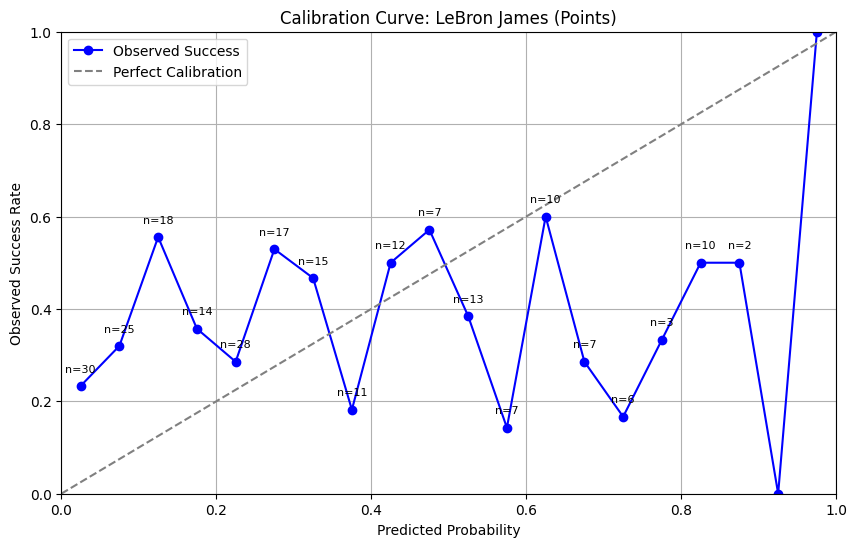


 Calibration Table:
Bin 0.00-0.05: Predicted Avg: 0.03, Observed Success Rate: 0.23 (n=30)
Bin 0.05-0.10: Predicted Avg: 0.08, Observed Success Rate: 0.32 (n=25)
Bin 0.10-0.15: Predicted Avg: 0.12, Observed Success Rate: 0.56 (n=18)
Bin 0.15-0.20: Predicted Avg: 0.18, Observed Success Rate: 0.36 (n=14)
Bin 0.20-0.25: Predicted Avg: 0.23, Observed Success Rate: 0.29 (n=28)
Bin 0.25-0.30: Predicted Avg: 0.28, Observed Success Rate: 0.53 (n=17)
Bin 0.30-0.35: Predicted Avg: 0.33, Observed Success Rate: 0.47 (n=15)
Bin 0.35-0.40: Predicted Avg: 0.38, Observed Success Rate: 0.18 (n=11)
Bin 0.40-0.45: Predicted Avg: 0.43, Observed Success Rate: 0.50 (n=12)
Bin 0.45-0.50: Predicted Avg: 0.47, Observed Success Rate: 0.57 (n=7)
Bin 0.50-0.55: Predicted Avg: 0.53, Observed Success Rate: 0.38 (n=13)
Bin 0.55-0.60: Predicted Avg: 0.58, Observed Success Rate: 0.14 (n=7)
Bin 0.60-0.65: Predicted Avg: 0.62, Observed Success Rate: 0.60 (n=10)
Bin 0.65-0.70: Predicted Avg: 0.68, Observed Success Rate:

In [7]:
def test_full_model_calibration(first_name, last_name, is_home_game=1, stat_name='points', threshold=30, num_recent=20, num_opponent=10, max_tests=200):
    """
    Calibrates the full player+matchup prediction model across many games (dynamic opponent detection).
    """
    print(f"\n Running full calibration for {first_name} {last_name} (Dynamic Opponent)...")

    # Ensure dates are correct
    if not np.issubdtype(player_stats['gameDate'].dtype, np.datetime64):
        player_stats['gameDate'] = pd.to_datetime(player_stats['gameDate'])

    filtered_stats = player_stats[player_stats['numMinutes'] >= 10]

    all_games = filtered_stats[
        (filtered_stats['firstName'] == first_name) &
        (filtered_stats['lastName'] == last_name)
    ].sort_values('gameDate')

    if all_games.empty:
        print(f" No data for {first_name} {last_name}.")
        return

    predicted_probs = []
    actual_results = []

    for i in range(num_recent, min(len(all_games), num_recent + max_tests)):
        # Progress counter
        if (i - num_recent + 1) % 25 == 0:
            print(f" Processed {i - num_recent + 1}/{min(max_tests, len(all_games)-num_recent)} games...")

        past_games = all_games.iloc[i-num_recent:i]
        future_game = all_games.iloc[i]

        if past_games.empty:
            continue

        # Detect opponent team dynamically
        opponent_team = future_game['opponentteamName']

        past_opponent_games = all_games[
            (all_games['opponentteamName'] == opponent_team) &
            (all_games['gameDate'] < future_game['gameDate'])
        ]
        recent_opponent_games = past_opponent_games[past_opponent_games['home'] == is_home_game].tail(num_opponent)

        recent_games = past_games[past_games['home'] == is_home_game]

        if recent_games.empty or recent_opponent_games.empty:
            continue

        recent_games = drop_highest_and_lowest(recent_games, column=stat_name)
        recent_opponent_games = drop_highest_and_lowest(recent_opponent_games, column=stat_name)

        if len(recent_games) < 5 or len(recent_opponent_games) < 3:
            continue

        # Prepare data
        recent_games = recent_games.reset_index(drop=True)
        recent_games['gameNumber'] = np.arange(len(recent_games))
        X_recent = recent_games[['gameNumber']]
        y_recent = recent_games[stat_name]

        recent_opponent_games = recent_opponent_games.reset_index(drop=True)
        recent_opponent_games['gameNumber'] = np.arange(len(recent_opponent_games))
        X_opponent = recent_opponent_games[['gameNumber']]
        y_opponent = recent_opponent_games[stat_name]

        # Random Forest Models
        model_recent_rf = RandomForestRegressor(max_depth=3, random_state=42)
        model_recent_rf.fit(X_recent, y_recent)

        model_opponent_rf = RandomForestRegressor(max_depth=3, random_state=42)
        model_opponent_rf.fit(X_opponent, y_opponent)

        pred_recent = model_recent_rf.predict(np.array([[len(recent_games)]]))[0]
        pred_opponent = model_opponent_rf.predict(np.array([[len(recent_opponent_games)]]))[0]
        final_pred = 0.6 * pred_recent + 0.4 * pred_opponent

        # Linear Regression for Spread
        model_recent_lr = LinearRegression()
        model_recent_lr.fit(X_recent, y_recent)

        model_opponent_lr = LinearRegression()
        model_opponent_lr.fit(X_opponent, y_opponent)

        y_recent_pred = model_recent_lr.predict(X_recent)
        y_opponent_pred = model_opponent_lr.predict(X_opponent)

        ss_recent_res = np.sum((y_recent - y_recent_pred)**2)
        ss_recent_tot = np.sum((y_recent - np.mean(y_recent))**2)
        r2_recent = 1 - ss_recent_res/ss_recent_tot

        ss_opponent_res = np.sum((y_opponent - y_opponent_pred)**2)
        ss_opponent_tot = np.sum((y_opponent - np.mean(y_opponent))**2)
        r2_opponent = 1 - ss_opponent_res/ss_opponent_tot

        avg_r2 = (r2_recent + r2_opponent) / 2
        base_std_dev = np.std(np.concatenate([y_recent, y_opponent]))
        adj_std_dev = base_std_dev * (1 - avg_r2)
        adj_std_dev = max(adj_std_dev, 1)

        # Predict probability of exceeding threshold
        prob = 1 - norm.cdf(threshold, final_pred, adj_std_dev)
        prob = min(prob, 0.99)

        predicted_probs.append(prob)
        actual_results.append(1 if future_game[stat_name] > threshold else 0)

    #Calibration Results
    if len(predicted_probs) == 0:
        print(" No games qualified for calibration.")
        return

    predicted_probs = np.array(predicted_probs)
    actual_results = np.array(actual_results)

    bins = np.linspace(0, 1, 21)  # 5% bins
    bin_indices = np.digitize(predicted_probs, bins) - 1

    bin_true_success = np.zeros(len(bins)-1)
    bin_total_counts = np.zeros(len(bins)-1)

    for idx, actual in zip(bin_indices, actual_results):
        if 0 <= idx < len(bin_true_success):
            bin_true_success[idx] += actual
            bin_total_counts[idx] += 1

    observed_success_rate = np.divide(bin_true_success, bin_total_counts, out=np.zeros_like(bin_true_success), where=bin_total_counts!=0)
    bin_midpoints = (bins[:-1] + bins[1:]) / 2

    #Plot
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(bin_midpoints, observed_success_rate, marker='o', linestyle='-', color='blue', label='Observed Success')
    ax.plot([0,1], [0,1], linestyle='--', color='gray', label='Perfect Calibration')

    for i, (mid, count) in enumerate(zip(bin_midpoints, bin_total_counts)):
        if count > 0:
            ax.annotate(f'n={int(count)}', (mid, observed_success_rate[i]+0.03),
                        ha='center', fontsize=8, color='black')

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Observed Success Rate')
    ax.set_title(f'Calibration Curve: {first_name} {last_name} ({stat_name.capitalize()})')
    ax.legend()
    plt.grid(True)
    plt.show()

    # Print Calibration Table
    print("\n Calibration Table:")
    for i in range(len(observed_success_rate)):
        if bin_total_counts[i] > 0:
            print(f"Bin {bins[i]:.2f}-{bins[i+1]:.2f}: Predicted Avg: {(bins[i]+bins[i+1])/2:.2f}, Observed Success Rate: {observed_success_rate[i]:.2f} (n={int(bin_total_counts[i])})")

    #Print Brier Score
    from sklearn.metrics import brier_score_loss
    brier = brier_score_loss(actual_results, predicted_probs)
    print(f"\n Brier Score: {brier:.4f}")


test_full_model_calibration('LeBron', 'James', is_home_game=1, stat_name='points', threshold=30, max_tests=500)


This model uses Random Forest Regression for the center, and a blend of
Linear Regression and Random Forest residuals for the spread.
The idea was that the Linear Regression spread was too wide, and the
Random Forest spread was too tight, so splitting the difference
could fix the issue.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


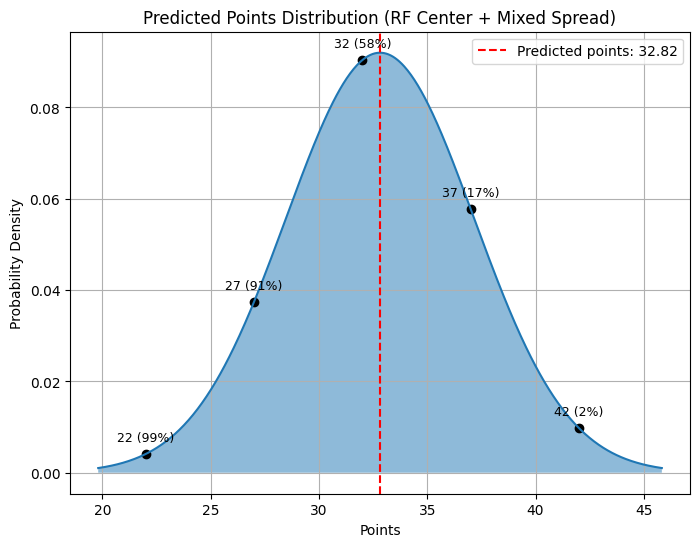


 Interactive Probability Slider for Points:


IntSlider(value=32, continuous_update=False, description='points', max=52, min=22)

Output()

(np.float64(32.82053333333333), np.float64(4.337045658061247))

In [8]:
def predict_stat_distribution_core(stat_name, first_name, last_name, opponent_team, is_home_game):
    """
    Silent core model: returns final_pred (mean) and adj_std_dev (spread).
    """
    if not np.issubdtype(player_stats['gameDate'].dtype, np.datetime64):
        player_stats['gameDate'] = pd.to_datetime(player_stats['gameDate'])

    filtered_stats = player_stats[player_stats['numMinutes'] >= 10]
    all_games = filtered_stats[
        (filtered_stats['firstName'] == first_name) &
        (filtered_stats['lastName'] == last_name)
    ].sort_values('gameDate')

    opponent_games = all_games[all_games['opponentteamName'] == opponent_team]

    if all_games.empty or opponent_games.empty:
        return None, None

    recent_games = all_games[all_games['home'] == is_home_game].tail(20)
    recent_opponent_games = opponent_games[opponent_games['home'] == is_home_game].tail(10)

    if recent_games.empty or recent_opponent_games.empty:
        return None, None

    recent_games = drop_highest_and_lowest(recent_games, column=stat_name)
    recent_opponent_games = drop_highest_and_lowest(recent_opponent_games, column=stat_name)

    if len(recent_games) < 5 or len(recent_opponent_games) < 3:
        return None, None

    # Recent
    recent_games = recent_games.reset_index(drop=True)
    recent_games['gameNumber'] = np.arange(len(recent_games))
    X_recent = recent_games[['gameNumber']]
    y_recent = recent_games[stat_name]

    # Matchup
    recent_opponent_games = recent_opponent_games.reset_index(drop=True)
    recent_opponent_games['gameNumber'] = np.arange(len(recent_opponent_games))
    X_opponent = recent_opponent_games[['gameNumber']]
    y_opponent = recent_opponent_games[stat_name]

    # Random Forest - Center
    model_recent_rf = RandomForestRegressor(max_depth=3, random_state=42)
    model_recent_rf.fit(X_recent, y_recent)

    model_opponent_rf = RandomForestRegressor(max_depth=3, random_state=42)
    model_opponent_rf.fit(X_opponent, y_opponent)

    pred_recent = model_recent_rf.predict(np.array([[len(recent_games)]]))[0]
    pred_opponent = model_opponent_rf.predict(np.array([[len(recent_opponent_games)]]))[0]
    final_pred = 0.6 * pred_recent + 0.4 * pred_opponent

    # Linear Model - Spread
    model_recent_lr = LinearRegression()
    model_recent_lr.fit(X_recent, y_recent)

    model_opponent_lr = LinearRegression()
    model_opponent_lr.fit(X_opponent, y_opponent)

    y_recent_pred_lr = model_recent_lr.predict(X_recent)
    y_opponent_pred_lr = model_opponent_lr.predict(X_opponent)

    ss_recent_lr = np.sum((y_recent - y_recent_pred_lr)**2)
    ss_opponent_lr = np.sum((y_opponent - y_opponent_pred_lr)**2)

    ss_recent_tot = np.sum((y_recent - np.mean(y_recent))**2)
    ss_opponent_tot = np.sum((y_opponent - np.mean(y_opponent))**2)

    r2_recent_lr = 1 - ss_recent_lr / ss_recent_tot
    r2_opponent_lr = 1 - ss_opponent_lr / ss_opponent_tot

    avg_r2_lr = (r2_recent_lr + r2_opponent_lr) / 2

    # Random Forest residuals (extra spread)
    y_recent_pred_rf = model_recent_rf.predict(X_recent)
    y_opponent_pred_rf = model_opponent_rf.predict(X_opponent)

    rf_residual_std = np.std(np.concatenate([
        y_recent - y_recent_pred_rf,
        y_opponent - y_opponent_pred_rf
    ]))

    # Base std dev
    base_std_dev = np.std(np.concatenate([y_recent, y_opponent]))

    # Blend spread (50% Linear R² adjustment, 50% Random Forest residual spread)
    spread_from_lr = base_std_dev * (1 - avg_r2_lr)
    blended_spread = 0.5 * spread_from_lr + 0.5 * rf_residual_std
    blended_spread = max(blended_spread, 1)  # minimum noise level

    return final_pred, blended_spread

def predict_stat_distribution(stat_name, first_name, last_name, opponent_team, is_home_game):
    """
    Full visual function: calls core, then plots, sliders, etc.
    """
    final_pred, adj_std_dev = predict_stat_distribution_core(stat_name, first_name, last_name, opponent_team, is_home_game)

    if final_pred is None or adj_std_dev is None:
        print("Not enough data to predict.")
        return None, None

    # Bell curve plotting
    x = np.linspace(final_pred - 3*adj_std_dev, final_pred + 3*adj_std_dev, 500)
    y = norm.pdf(x, final_pred, adj_std_dev)

    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(x, y)
    ax.fill_between(x, y, alpha=0.5)
    ax.axvline(final_pred, color='red', linestyle='--', label=f'Predicted {stat_name}: {final_pred:.2f}')

    thresholds = []
    if final_pred <= 10:
        thresholds = [int(final_pred - 4), int(final_pred - 2), int(final_pred), int(final_pred + 2), int(final_pred + 4)]
    elif final_pred <= 20:
        thresholds = [int(final_pred - 6), int(final_pred - 3), int(final_pred), int(final_pred + 3), int(final_pred + 6)]
    else:
        thresholds = [int(final_pred - 10), int(final_pred - 5), int(final_pred), int(final_pred + 5), int(final_pred + 10)]
    thresholds = [thresh for thresh in thresholds if thresh > 0]

    for thresh in thresholds:
        y_thresh = norm.pdf(thresh, final_pred, adj_std_dev)
        prob = min((1 - norm.cdf(thresh, final_pred, adj_std_dev)) * 100, 99)
        ax.scatter(thresh, y_thresh, color='black')
        ax.text(thresh, y_thresh + max(y)*0.03, f'{thresh} ({prob:.0f}%)', ha='center', fontsize=9, color='black')

    ax.set_title(f'Predicted {stat_name.capitalize()} Distribution (RF Center + Mixed Spread)')
    ax.set_xlabel(f'{stat_name.capitalize()}')
    ax.set_ylabel('Probability Density')
    ax.legend()
    plt.grid(True)
    plt.show()

    # Interactive Probability Slider
    print(f"\n Interactive Probability Slider for {stat_name.capitalize()}:")
    slider = widgets.IntSlider(
        value=int(final_pred),
        min=int(final_pred - 10),
        max=int(final_pred + 20),
        step=1,
        description=f'{stat_name}',
        continuous_update=False
    )
    def calculate_probability(threshold):
        prob = 1 - norm.cdf(threshold, final_pred, adj_std_dev)
        prob = min(prob, 0.99)
        print(f" Probability of more than {threshold} {stat_name}: {prob*100:.2f}%")
    output = widgets.interactive_output(calculate_probability, {'threshold': slider})
    display(slider, output)

    return final_pred, adj_std_dev


predict_stat_distribution('points', 'Stephen', 'Curry', 'Rockets', is_home_game=1)


This model tests the previous model across multiple players over time.
Conclusion: The model becomes very overconfident at higher values.


 Running full calibration across 10 players...

 Calibrating LeBron James...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/


 Calibrating Stephen Curry...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/


 Calibrating Jarred Vanderbilt...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/


 Calibrating Mike Conley...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/


 Calibrating Naz Reid...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/


 Calibrating Derrick White...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/


 Calibrating Dorian Finney-Smith...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/


 Calibrating Sam Hauser...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/


 Calibrating Rui Hacchimura...
No games found for Rui Hacchimura. Skipping...

 Calibrating Rudy Gobert...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

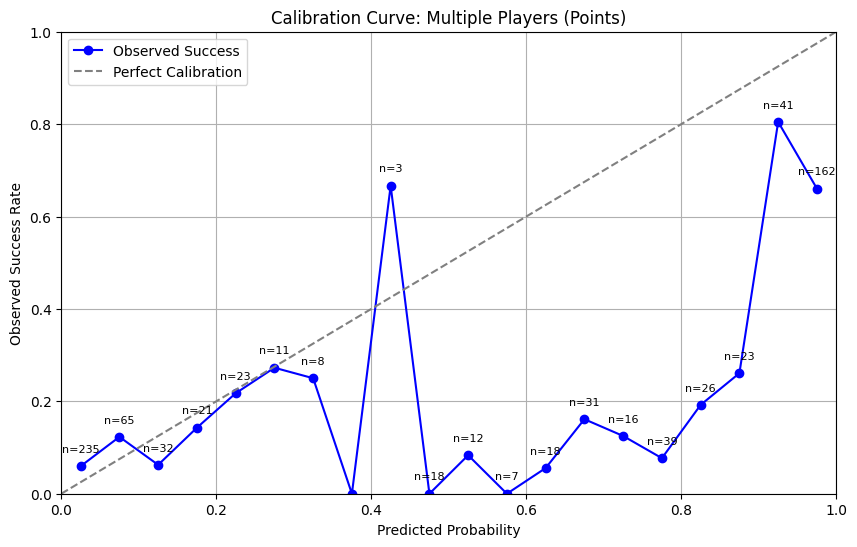


 Calibration Table:
Bin 0.00-0.05: Predicted Avg: 0.03, Observed Success Rate: 0.06 (n=235)
Bin 0.05-0.10: Predicted Avg: 0.08, Observed Success Rate: 0.12 (n=65)
Bin 0.10-0.15: Predicted Avg: 0.12, Observed Success Rate: 0.06 (n=32)
Bin 0.15-0.20: Predicted Avg: 0.18, Observed Success Rate: 0.14 (n=21)
Bin 0.20-0.25: Predicted Avg: 0.23, Observed Success Rate: 0.22 (n=23)
Bin 0.25-0.30: Predicted Avg: 0.28, Observed Success Rate: 0.27 (n=11)
Bin 0.30-0.35: Predicted Avg: 0.33, Observed Success Rate: 0.25 (n=8)
Bin 0.40-0.45: Predicted Avg: 0.43, Observed Success Rate: 0.67 (n=3)
Bin 0.45-0.50: Predicted Avg: 0.47, Observed Success Rate: 0.00 (n=18)
Bin 0.50-0.55: Predicted Avg: 0.53, Observed Success Rate: 0.08 (n=12)
Bin 0.55-0.60: Predicted Avg: 0.58, Observed Success Rate: 0.00 (n=7)
Bin 0.60-0.65: Predicted Avg: 0.62, Observed Success Rate: 0.06 (n=18)
Bin 0.65-0.70: Predicted Avg: 0.68, Observed Success Rate: 0.16 (n=31)
Bin 0.70-0.75: Predicted Avg: 0.73, Observed Success Rate:

In [9]:
def test_full_model_calibration_multiple_players(player_list, is_home_game=1, stat_name='points', threshold=30, num_recent=20, num_opponent=10, max_tests=200):
    """
    Calibrates model across multiple players.
    """
    print(f"\n Running full calibration across {len(player_list)} players...")

    predicted_probs = []
    actual_results = []

    for first_name, last_name in player_list:
        print(f"\n Calibrating {first_name} {last_name}...")

        if not np.issubdtype(player_stats['gameDate'].dtype, np.datetime64):
            player_stats['gameDate'] = pd.to_datetime(player_stats['gameDate'])

        filtered_stats = player_stats[player_stats['numMinutes'] >= 10]

        all_games = filtered_stats[
            (filtered_stats['firstName'] == first_name) &
            (filtered_stats['lastName'] == last_name)
        ].sort_values('gameDate')

        if all_games.empty:
            print(f"No games found for {first_name} {last_name}. Skipping...")
            continue

        for i in range(num_recent, min(len(all_games), num_recent + max_tests)):
            past_games = all_games.iloc[i-num_recent:i]
            future_game = all_games.iloc[i]

            if past_games.empty:
                continue

            opponent_team = future_game['opponentteamName']

            final_pred, adj_std_dev = predict_stat_distribution_core(stat_name, first_name, last_name, opponent_team, is_home_game)

            if final_pred is None or adj_std_dev is None:
                continue

            prob = 1 - norm.cdf(threshold, final_pred, adj_std_dev)
            prob = min(prob, 0.99)

            predicted_probs.append(prob)
            actual_results.append(1 if future_game[stat_name] > threshold else 0)

    # Calibration Results
    if len(predicted_probs) == 0:
        print(" No games qualified for calibration.")
        return

    predicted_probs = np.array(predicted_probs)
    actual_results = np.array(actual_results)

    bins = np.linspace(0, 1, 21)
    bin_indices = np.digitize(predicted_probs, bins) - 1

    bin_true_success = np.zeros(len(bins)-1)
    bin_total_counts = np.zeros(len(bins)-1)

    for idx, actual in zip(bin_indices, actual_results):
        if 0 <= idx < len(bin_true_success):
            bin_true_success[idx] += actual
            bin_total_counts[idx] += 1

    observed_success_rate = np.divide(bin_true_success, bin_total_counts, out=np.zeros_like(bin_true_success), where=bin_total_counts!=0)
    bin_midpoints = (bins[:-1] + bins[1:]) / 2

    #Plot
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(bin_midpoints, observed_success_rate, marker='o', linestyle='-', color='blue', label='Observed Success')
    ax.plot([0,1], [0,1], linestyle='--', color='gray', label='Perfect Calibration')

    for i, (mid, count) in enumerate(zip(bin_midpoints, bin_total_counts)):
        if count > 0:
            ax.annotate(f'n={int(count)}', (mid, observed_success_rate[i]+0.03),
                        ha='center', fontsize=8, color='black')

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Observed Success Rate')
    ax.set_title(f'Calibration Curve: Multiple Players ({stat_name.capitalize()})')
    ax.legend()
    plt.grid(True)
    plt.show()

    #Print Calibration Table
    print("\n Calibration Table:")
    for i in range(len(observed_success_rate)):
        if bin_total_counts[i] > 0:
            print(f"Bin {bins[i]:.2f}-{bins[i+1]:.2f}: Predicted Avg: {(bins[i]+bins[i+1])/2:.2f}, Observed Success Rate: {observed_success_rate[i]:.2f} (n={int(bin_total_counts[i])})")

    #Brier Score
    from sklearn.metrics import brier_score_loss
    brier = brier_score_loss(actual_results, predicted_probs)
    print(f"\n Brier Score: {brier:.4f}")


players = [
    ('LeBron', 'James'),
    ('Stephen', 'Curry'),
    ('Jarred', 'Vanderbilt'),
    ('Mike', 'Conley'),
    ('Naz', 'Reid'),
    ('Derrick', 'White'),
    ('Dorian', 'Finney-Smith'),
    ('Sam', 'Hauser'),
    ('Rui', 'Hacchimura'),
    ('Rudy', 'Gobert')
]

test_full_model_calibration_multiple_players(players, is_home_game=1, stat_name='points', threshold=15, max_tests=100)



This model uses Kernel Density Estimation for the player prediction. This will result in a more dynamic spread, as human players cannot be simplified into a normal distribution curve.
Conclusion: The spread seems more realistic, but the center prediction isn't accurate.

<ipython-input-10-559f4e36c3a8>:79: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prob = np.trapz(y[mask], x[mask])


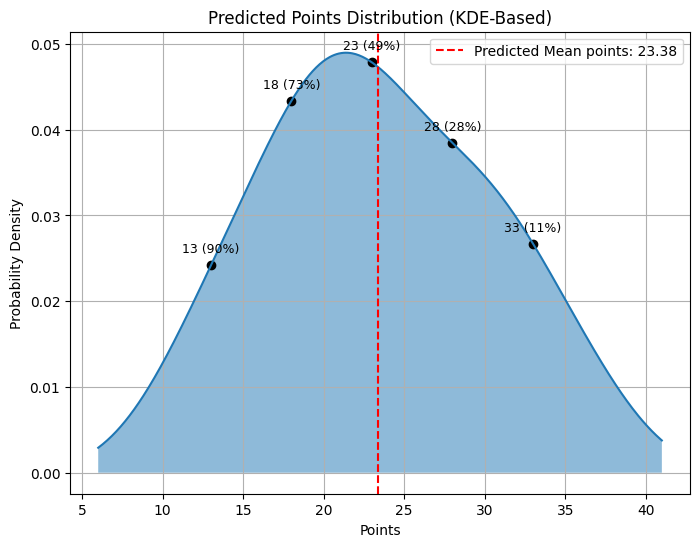


 Interactive Probability Slider for Points:


IntSlider(value=23, continuous_update=False, description='points', max=41, min=6)

Output()

(np.float64(23.384615384615383),
 <scipy.stats._kde.gaussian_kde at 0x7d24c8b34c10>)

In [10]:
#KDE
def predict_stat_distribution_core(stat_name, first_name, last_name, opponent_team, is_home_game):
    """
    Silent core model: returns final predicted KDE object based on real past data.
    """
    if not np.issubdtype(player_stats['gameDate'].dtype, np.datetime64):
        player_stats['gameDate'] = pd.to_datetime(player_stats['gameDate'])

    filtered_stats = player_stats[player_stats['numMinutes'] >= 10]
    all_games = filtered_stats[
        (filtered_stats['firstName'] == first_name) &
        (filtered_stats['lastName'] == last_name)
    ].sort_values('gameDate')

    opponent_games = all_games[all_games['opponentteamName'] == opponent_team]

    if all_games.empty or opponent_games.empty:
        return None, None

    recent_games = all_games[all_games['home'] == is_home_game].tail(20)
    recent_opponent_games = opponent_games[opponent_games['home'] == is_home_game].tail(10)

    if recent_games.empty or recent_opponent_games.empty:
        return None, None

    recent_games = drop_highest_and_lowest(recent_games, column=stat_name)
    recent_opponent_games = drop_highest_and_lowest(recent_opponent_games, column=stat_name)

    if len(recent_games) < 5 or len(recent_opponent_games) < 3:
        return None, None

    y_recent = recent_games[stat_name]
    y_opponent = recent_opponent_games[stat_name]

    # Final combined data for KDE
    combined_data = np.concatenate([y_recent, y_opponent])

    # Build KDE from actual past stat values
    kde = gaussian_kde(combined_data, bw_method='scott')  # 'scott' is good general smoothing

    return kde, combined_data


def predict_stat_distribution(stat_name, first_name, last_name, opponent_team, is_home_game):
    """
    Full visual version: builds KDE curve, shows probability sliders and plots.
    """
    kde, combined_data = predict_stat_distribution_core(stat_name, first_name, last_name, opponent_team, is_home_game)

    if kde is None or combined_data is None:
        print("Not enough data to predict.")
        return None, None

    final_pred = np.mean(combined_data)  # Estimated "average" stat performance

    # Create x axis points
    x_min = min(combined_data) - 5
    x_max = max(combined_data) + 5
    x = np.linspace(x_min, x_max, 500)
    y = kde(x)

    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(x, y)
    ax.fill_between(x, y, alpha=0.5)
    ax.axvline(final_pred, color='red', linestyle='--', label=f'Predicted Mean {stat_name}: {final_pred:.2f}')

    thresholds = []
    if final_pred <= 10:
        thresholds = [int(final_pred - 4), int(final_pred - 2), int(final_pred), int(final_pred + 2), int(final_pred + 4)]
    elif final_pred <= 20:
        thresholds = [int(final_pred - 6), int(final_pred - 3), int(final_pred), int(final_pred + 3), int(final_pred + 6)]
    else:
        thresholds = [int(final_pred - 10), int(final_pred - 5), int(final_pred), int(final_pred + 5), int(final_pred + 10)]
    thresholds = [thresh for thresh in thresholds if thresh > 0]

    for thresh in thresholds:
        # Integrate KDE from threshold to +inf
        mask = x >= thresh
        prob = np.trapz(y[mask], x[mask])
        prob = min(prob, 0.99)

        y_thresh = kde(thresh)[0]
        ax.scatter(thresh, y_thresh, color='black')
        ax.text(thresh, y_thresh + max(y)*0.03, f'{thresh} ({prob*100:.0f}%)', ha='center', fontsize=9, color='black')

    ax.set_title(f'Predicted {stat_name.capitalize()} Distribution (KDE-Based)')
    ax.set_xlabel(f'{stat_name.capitalize()}')
    ax.set_ylabel('Probability Density')
    ax.legend()
    plt.grid(True)
    plt.show()

    #Interactive slider
    print(f"\n Interactive Probability Slider for {stat_name.capitalize()}:")
    slider = widgets.IntSlider(
        value=int(final_pred),
        min=int(x_min),
        max=int(x_max),
        step=1,
        description=f'{stat_name}',
        continuous_update=False
    )

    def calculate_probability(threshold):
        mask = x >= threshold
        prob = np.trapz(y[mask], x[mask])
        prob = min(prob, 0.99)
        print(f"Probability of more than {threshold} {stat_name}: {prob*100:.2f}%")

    output = widgets.interactive_output(calculate_probability, {'threshold': slider})
    display(slider, output)

    return final_pred, kde

predict_stat_distribution('points', 'Stephen', 'Curry', 'Rockets', is_home_game=1)


This model uses the most accurate center predictor, Random Forest Regression, along with the most realistic spread generator, which is Kernel Density Estimation.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipython-input-11-fccf38737e46>:102: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prob = np.trapz(y[mask], x[mask])


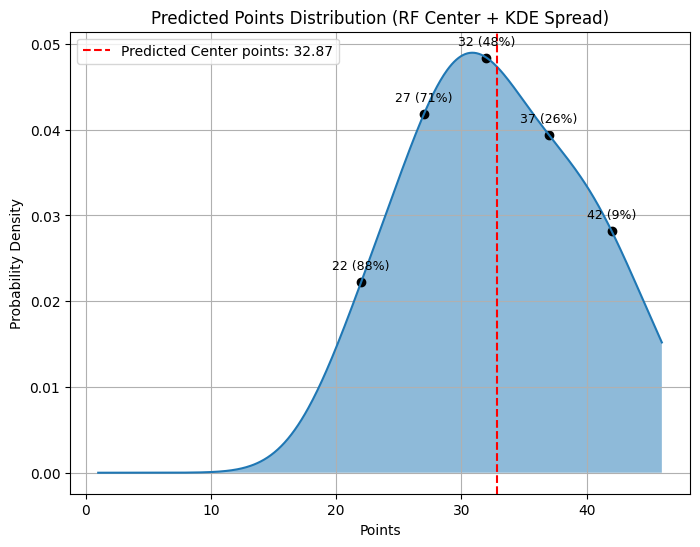


Interactive Probability Slider for Points:


IntSlider(value=32, continuous_update=False, description='points', max=46, min=1)

Output()

(np.float64(32.866),
 <function __main__.predict_stat_distribution_core.<locals>.shifted_kde(x)>)

In [11]:
#RF center KDE spread
def predict_stat_distribution_core(stat_name, first_name, last_name, opponent_team, is_home_game):
    """
    Silent core model: predicts center with Random Forest, models spread with shifted KDE.
    """
    if not np.issubdtype(player_stats['gameDate'].dtype, np.datetime64):
        player_stats['gameDate'] = pd.to_datetime(player_stats['gameDate'])

    filtered_stats = player_stats[player_stats['numMinutes'] >= 10]
    all_games = filtered_stats[
        (filtered_stats['firstName'] == first_name) &
        (filtered_stats['lastName'] == last_name)
    ].sort_values('gameDate')

    opponent_games = all_games[all_games['opponentteamName'] == opponent_team]

    if all_games.empty or opponent_games.empty:
        return None, None, None

    recent_games = all_games[all_games['home'] == is_home_game].tail(20)
    recent_opponent_games = opponent_games[opponent_games['home'] == is_home_game].tail(10)

    if recent_games.empty or recent_opponent_games.empty:
        return None, None, None

    recent_games = drop_highest_and_lowest(recent_games, column=stat_name)
    recent_opponent_games = drop_highest_and_lowest(recent_opponent_games, column=stat_name)

    if len(recent_games) < 5 or len(recent_opponent_games) < 3:
        return None, None, None

    recent_games = recent_games.reset_index(drop=True)
    recent_games['gameNumber'] = np.arange(len(recent_games))

    recent_opponent_games = recent_opponent_games.reset_index(drop=True)
    recent_opponent_games['gameNumber'] = np.arange(len(recent_opponent_games))

    X_recent = recent_games[['gameNumber']]
    y_recent = recent_games[stat_name]

    X_opponent = recent_opponent_games[['gameNumber']]
    y_opponent = recent_opponent_games[stat_name]

    #Train Random Forest for center prediction
    model_recent_rf = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=42)
    model_recent_rf.fit(X_recent, y_recent)

    model_opponent_rf = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=42)
    model_opponent_rf.fit(X_opponent, y_opponent)

    pred_recent = model_recent_rf.predict([[len(X_recent)]])[0]
    pred_opponent = model_opponent_rf.predict([[len(X_opponent)]])[0]

    final_pred = 0.6 * pred_recent + 0.4 * pred_opponent

    #Build KDE from real past stats
    combined_data = np.concatenate([y_recent, y_opponent])
    kde_original = gaussian_kde(combined_data, bw_method='scott')

    #Shift KDE so that its mean matches RF predicted center
    original_mean = np.mean(combined_data)
    shift_amount = final_pred - original_mean

    def shifted_kde(x):
        return kde_original(x - shift_amount)

    return final_pred, shifted_kde, (min(combined_data), max(combined_data))


def predict_stat_distribution(stat_name, first_name, last_name, opponent_team, is_home_game):
    """
    Full visual version: uses Random Forest for center, KDE for spread.
    """
    final_pred, shifted_kde, (data_min, data_max) = predict_stat_distribution_core(stat_name, first_name, last_name, opponent_team, is_home_game)

    if final_pred is None or shifted_kde is None:
        print("Not enough data to predict.")
        return None, None

    # Create x axis points
    x_min = data_min - 10
    x_max = data_max + 10
    x = np.linspace(x_min, x_max, 500)
    y = shifted_kde(x)

    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(x, y)
    ax.fill_between(x, y, alpha=0.5)
    ax.axvline(final_pred, color='red', linestyle='--', label=f'Predicted Center {stat_name}: {final_pred:.2f}')

    thresholds = []
    if final_pred <= 10:
        thresholds = [int(final_pred - 4), int(final_pred - 2), int(final_pred), int(final_pred + 2), int(final_pred + 4)]
    elif final_pred <= 20:
        thresholds = [int(final_pred - 6), int(final_pred - 3), int(final_pred), int(final_pred + 3), int(final_pred + 6)]
    else:
        thresholds = [int(final_pred - 10), int(final_pred - 5), int(final_pred), int(final_pred + 5), int(final_pred + 10)]
    thresholds = [thresh for thresh in thresholds if thresh > 0]

    for thresh in thresholds:
        mask = x >= thresh
        prob = np.trapz(y[mask], x[mask])
        prob = min(prob, 0.99)

        y_thresh = shifted_kde(thresh)[0]
        ax.scatter(thresh, y_thresh, color='black')
        ax.text(thresh, y_thresh + max(y)*0.03, f'{thresh} ({prob*100:.0f}%)', ha='center', fontsize=9, color='black')

    ax.set_title(f'Predicted {stat_name.capitalize()} Distribution (RF Center + KDE Spread)')
    ax.set_xlabel(f'{stat_name.capitalize()}')
    ax.set_ylabel('Probability Density')
    ax.legend()
    plt.grid(True)
    plt.show()

    #Interactive slider
    print(f"\nInteractive Probability Slider for {stat_name.capitalize()}:")
    slider = widgets.IntSlider(
        value=int(final_pred),
        min=int(x_min),
        max=int(x_max),
        step=1,
        description=f'{stat_name}',
        continuous_update=False
    )

    def calculate_probability(threshold):
        mask = x >= threshold
        prob = np.trapz(y[mask], x[mask])
        prob = min(prob, 0.99)
        print(f"Probability of more than {threshold} {stat_name}: {prob*100:.2f}%")

    output = widgets.interactive_output(calculate_probability, {'threshold': slider})
    display(slider, output)

    return final_pred, shifted_kde

predict_stat_distribution('points', 'Stephen', 'Curry', 'Rockets', is_home_game=1)


This test checks the effectiveness of using Random Forest Regression for the center prediction and using Kernel Density Estimation for the spread.
Conclusion: While the model is still overconfident at higher values, it is much more accurate than previous models.


Running full calibration across 10 players...

Calibrating LeBron James...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipython-input-12-c6f05edee3fa>:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prob = np.trapz(y[mask], x[mask])
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipy


Calibrating Stephen Curry...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipython-input-12-c6f05edee3fa>:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prob = np.trapz(y[mask], x[mask])
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipy


Calibrating Jarred Vanderbilt...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipython-input-12-c6f05edee3fa>:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prob = np.trapz(y[mask], x[mask])
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipy


Calibrating Mike Conley...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipython-input-12-c6f05edee3fa>:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prob = np.trapz(y[mask], x[mask])
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipy


Calibrating Naz Reid...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipython-input-12-c6f05edee3fa>:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prob = np.trapz(y[mask], x[mask])
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipy


Calibrating Derrick White...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipython-input-12-c6f05edee3fa>:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prob = np.trapz(y[mask], x[mask])
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipy


Calibrating Dorian Finney-Smith...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipython-input-12-c6f05edee3fa>:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prob = np.trapz(y[mask], x[mask])
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipy


Calibrating Sam Hauser...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipython-input-12-c6f05edee3fa>:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prob = np.trapz(y[mask], x[mask])
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipy


Calibrating Rui Hacchimura...
No games found for Rui Hacchimura. Skipping...

Calibrating Rudy Gobert...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipython-input-12-c6f05edee3fa>:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prob = np.trapz(y[mask], x[mask])
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipy

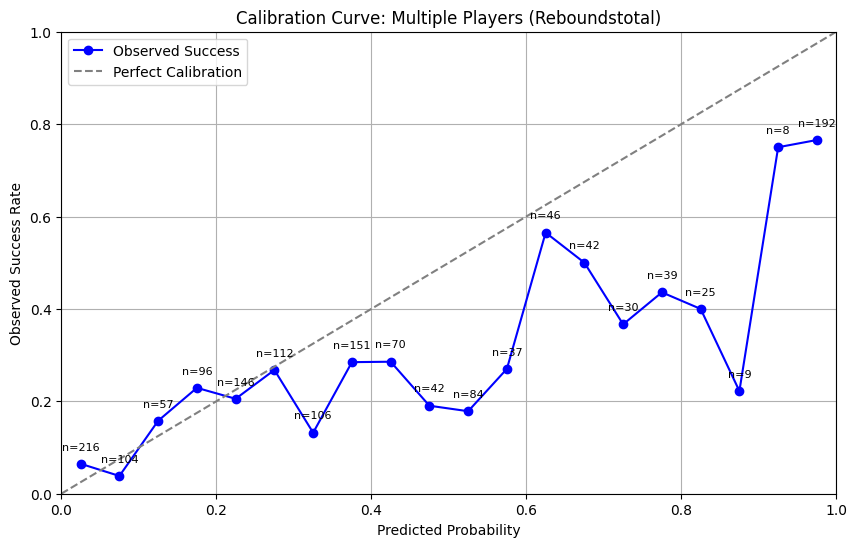


Calibration Table:
Bin 0.00-0.05: Predicted Avg: 0.03, Observed Success Rate: 0.06 (n=216)
Bin 0.05-0.10: Predicted Avg: 0.08, Observed Success Rate: 0.04 (n=104)
Bin 0.10-0.15: Predicted Avg: 0.12, Observed Success Rate: 0.16 (n=57)
Bin 0.15-0.20: Predicted Avg: 0.18, Observed Success Rate: 0.23 (n=96)
Bin 0.20-0.25: Predicted Avg: 0.23, Observed Success Rate: 0.21 (n=146)
Bin 0.25-0.30: Predicted Avg: 0.28, Observed Success Rate: 0.27 (n=112)
Bin 0.30-0.35: Predicted Avg: 0.33, Observed Success Rate: 0.13 (n=106)
Bin 0.35-0.40: Predicted Avg: 0.38, Observed Success Rate: 0.28 (n=151)
Bin 0.40-0.45: Predicted Avg: 0.43, Observed Success Rate: 0.29 (n=70)
Bin 0.45-0.50: Predicted Avg: 0.47, Observed Success Rate: 0.19 (n=42)
Bin 0.50-0.55: Predicted Avg: 0.53, Observed Success Rate: 0.18 (n=84)
Bin 0.55-0.60: Predicted Avg: 0.58, Observed Success Rate: 0.27 (n=37)
Bin 0.60-0.65: Predicted Avg: 0.62, Observed Success Rate: 0.57 (n=46)
Bin 0.65-0.70: Predicted Avg: 0.68, Observed Succes

In [12]:
#test
def test_full_model_calibration_multiple_players(player_list, is_home_game=1, stat_name='points', threshold=30, num_recent=20, max_tests=200):
    """
    Calibrates the full RF+KDE hybrid model across multiple players.
    """
    print(f"\nRunning full calibration across {len(player_list)} players...")

    predicted_probs = []
    actual_results = []

    for first_name, last_name in player_list:
        print(f"\nCalibrating {first_name} {last_name}...")

        if not np.issubdtype(player_stats['gameDate'].dtype, np.datetime64):
            player_stats['gameDate'] = pd.to_datetime(player_stats['gameDate'])

        filtered_stats = player_stats[player_stats['numMinutes'] >= 10]

        all_games = filtered_stats[
            (filtered_stats['firstName'] == first_name) &
            (filtered_stats['lastName'] == last_name)
        ].sort_values('gameDate')

        if all_games.empty:
            print(f"No games found for {first_name} {last_name}. Skipping...")
            continue

        for i in range(num_recent, min(len(all_games), num_recent + max_tests)):
            past_games = all_games.iloc[i-num_recent:i]
            future_game = all_games.iloc[i]

            if past_games.empty:
                continue

            opponent_team = future_game['opponentteamName']

            final_pred, shifted_kde, _ = predict_stat_distribution_core(stat_name, first_name, last_name, opponent_team, is_home_game)

            if final_pred is None or shifted_kde is None:
                continue

            # Now calculate probability
            x = np.linspace(final_pred - 30, final_pred + 30, 500)
            y = shifted_kde(x)

            mask = x >= threshold
            prob = np.trapz(y[mask], x[mask])
            prob = min(prob, 0.99)

            predicted_probs.append(prob)
            actual_results.append(1 if future_game[stat_name] > threshold else 0)

    #Calibration Results
    if len(predicted_probs) == 0:
        print("No games qualified for calibration.")
        return

    predicted_probs = np.array(predicted_probs)
    actual_results = np.array(actual_results)

    bins = np.linspace(0, 1, 21)  # 5% bins
    bin_indices = np.digitize(predicted_probs, bins) - 1

    bin_true_success = np.zeros(len(bins)-1)
    bin_total_counts = np.zeros(len(bins)-1)

    for idx, actual in zip(bin_indices, actual_results):
        if 0 <= idx < len(bin_true_success):
            bin_true_success[idx] += actual
            bin_total_counts[idx] += 1

    observed_success_rate = np.divide(bin_true_success, bin_total_counts, out=np.zeros_like(bin_true_success), where=bin_total_counts!=0)
    bin_midpoints = (bins[:-1] + bins[1:]) / 2

    #Plot
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(bin_midpoints, observed_success_rate, marker='o', linestyle='-', color='blue', label='Observed Success')
    ax.plot([0,1], [0,1], linestyle='--', color='gray', label='Perfect Calibration')

    for i, (mid, count) in enumerate(zip(bin_midpoints, bin_total_counts)):
        if count > 0:
            ax.annotate(f'n={int(count)}', (mid, observed_success_rate[i]+0.03),
                        ha='center', fontsize=8, color='black')

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Observed Success Rate')
    ax.set_title(f'Calibration Curve: Multiple Players ({stat_name.capitalize()})')
    ax.legend()
    plt.grid(True)
    plt.show()

    #Print Calibration Table
    print("\nCalibration Table:")
    for i in range(len(observed_success_rate)):
        if bin_total_counts[i] > 0:
            print(f"Bin {bins[i]:.2f}-{bins[i+1]:.2f}: Predicted Avg: {(bins[i]+bins[i+1])/2:.2f}, Observed Success Rate: {observed_success_rate[i]:.2f} (n={int(bin_total_counts[i])})")

    #Brier Score
    from sklearn.metrics import brier_score_loss
    brier = brier_score_loss(actual_results, predicted_probs)
    print(f"\nBrier Score: {brier:.4f}")


players = [
    ('LeBron', 'James'),
    ('Stephen', 'Curry'),
    ('Jarred', 'Vanderbilt'),
    ('Mike', 'Conley'),
    ('Naz', 'Reid'),
    ('Derrick', 'White'),
    ('Dorian', 'Finney-Smith'),
    ('Sam', 'Hauser'),
    ('Rui', 'Hacchimura'),
    ('Rudy', 'Gobert')
]

test_full_model_calibration_multiple_players(
    players,
    is_home_game=1,
    stat_name='reboundsTotal',
    threshold=6,
    num_recent=20,
    max_tests=200
)

In this project, we successfully predicted NBA player points, rebounds, and assists based on historical game statistics.
Using Stephen Curry as an example, the final version of the data used was gathered before Warriors vs. Rockets Game 3 of the 2025 NBA Playoffs Round 1. The model preicted Steph to score 33 points and he ended up scoring 36.
Random Forest Regression outperformed Linear Regression in terms of finding the central prediction.
Kernel Density Estimation resulted in the most realistic spread.
Future improvements would include adding context like trends for the opponent defensive strength, injury reports, as well as specific player tracking data like points from specific spots on the court.